# Trabajo integrador - Parte 3
## Aprendizaje No Supervisado
**Nombre**:

## Ejercicio 8

Para este ejercicio vamos a utilizar el dataset de _digits_ MNIST:

* [MNIST](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) (Ejercicio 4)

1. Aplicar PCA (validar que se cumplan las condiciones), ¿Cuántas componentes necesitamos para explicar el 80% de la varianza?
2. Gráficar la variación acumulada para cada caso.
3. Utilizando [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).
Agrupar el dataset transformado (ejercicio de PCA) y agrupar en clusters de $k=10$ y $k=2$.
4. Graficar los resultados con los distintos k's usando las primeras dos componentes principales como ejes x,y.
5. Explique. ¿Cuál fue la ganancia de usar PCA en conjunto con k-means?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento de modelos de prueba
from sklearn.linear_model import LinearRegression

# Evaluación de modelos de prueba
from sklearn.metrics import mean_squared_error

# Crear datasets
from sklearn.datasets import make_regression

In [12]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import normalize 
from sklearn.decomposition import PCA

In [31]:
### 1. Aplicar PCA (validar que se cumplan las condiciones), 
### ¿Cuántas componentes necesitamos para explicar el 80% de la varianza?

# Se utiliza la clase disponible en el archivo PCA-Fashion_MNIST disponible en los ejemplos de la clase 6

class PCA_MNIST:
    def __init__(self, X, y, n_components, whiten = False):
        '''
        inputs: 
            X                    - dataset de entrada
            y                    - labels
            n_components         - cantidad de componentes principales a usar
            whiten               - indica si se multiplica los elementos por
                                   la raiz cuadrada de X.shape[0] y se divide por los valores singulares --> varianza unitaria
        '''
        self.X = X
        self.n_components = n_components
        self.with_whiten = whiten
        self.y = y
        
        # Normalizamos el dataset
        #self.scaler = StandardScaler()
        # Ver diferencias entre StandardScaler y Normalize
        #self.X_norm = self.scaler.fit_transform(X)
        self.X_norm = normalize(X)
        
        # Aplicamos PCA al dataset normalizado
        self.PCAModel = PCA(n_components=self.n_components, whiten=self.with_whiten)
        self.X_norm_r = self.PCAModel.fit_transform(self.X_norm)
        
    def PCA_transform(self, X):
        return self.PCAModel.transform(X)

    def PCA_reconstruct(self, X_transformed):
        return self.PCAModel.inverse_transform(X_transformed) 
    
    def InterpretUsingModel(self, X):
        return self.PCAModel.inverse_transform(self.PCAModel.transform(X))
    
    def variance_plot(self, n_components):
        plt.subplot(1, 1, 1)
        plt.plot(range(n_components), self.PCAModel.explained_variance_ratio_[:n_components])
        plt.plot(range(n_components), np.cumsum(self.PCAModel.explained_variance_ratio_[:n_components]))
        plt.title("Varianza explicada por componente y Cumulativa ", fontsize=10)

    def last_n_components(self, n_components):
        X_norm = self.X_norm.T
        S = X_norm @ X_norm.T
        eigvals, eigvecs = np.linalg.eig(S) 
        order = np.argsort(eigvals) 
        B = eigvecs[:, order[:n_components]]
        C = B.T @ X_norm 
        X_rec = B @ C 
        X_rec = X_rec.T 
        return X_rec
    
    @staticmethod
    def plot_image(x):
        plt.imshow(x.reshape((28, 28)), cmap='gray')
    
    def plot_example(self, idx):
        plt.grid(True)
        plt.title("Ejemplo de {}".format(y_mapping[self.y[idx]]))
        self.plot_image(self.X[idx, :])
    
    @staticmethod
    def MSE(X, vector):
        n = X.shape[1]
        return np.sum((X - vector) ** 2, axis=1) / n
    
    def plot_reconstructions(self, X, numReconstructions=5):
        numSamples = np.shape(X)[0]
        numReconstructions = min(numReconstructions, numSamples)
        numReconstructionsPerFigure = min(5, numReconstructions)
        numFigures = int(np.ceil(float(numReconstructions)/numReconstructionsPerFigure))
                
        for figureidx in range(numFigures):
            plt.figure(figsize = (18, 18))
            for plotCol in range(numReconstructionsPerFigure):
                data_idx = np.random.randint(numSamples)
                originalImage = X[data_idx,:].ravel()
                reconstructedImage = self.InterpretUsingModel(np.reshape(X[data_idx,:],[1,-1])).ravel()
                diffImage = abs(originalImage - reconstructedImage)
                
                # original image
                plt.subplot(3,numReconstructionsPerFigure,0*numReconstructionsPerFigure+plotCol+1)
                self.plot_image(originalImage)
                plt.title('Imagen original') 
                plt.axis('off')
                    
                # reconstred image
                plt.subplot(3,numReconstructionsPerFigure,1*numReconstructionsPerFigure+plotCol+1)
                self.plot_image(reconstructedImage) 
                plt.title('Imagen reconstruida') 
                plt.axis('off')

                # diff image
                plt.subplot(3,numReconstructionsPerFigure,2*numReconstructionsPerFigure+plotCol+1)
                self.plot_image(diffImage) 
                plt.title('Diferencia absoluta')
                plt.axis('off')
            plt.tight_layout()
    
    def quantile_records(self, X, vector, q=0.5):
        """
        Devuelve el cuantil q del ECM entre la salida original y transformada para un determinado componente.
        """
        errors = self.MSE(X, vector)
        q_value = np.quantile(errors, q, method="lower")
        record = errors==q_value
        return X[record, :]
    
    def plot_quartiles(self, X, trans, n):
        fig, axarr = plt.subplots(n, 7, figsize=(12, n*2))
        for i in range(n):
            vector = trans.components_[i, :]
            sns.heatmap(self.quantile_records(X, vector, q=0.02).reshape(28, 28), cmap='gray_r', ax=axarr[i][0], cbar=False)
            axarr[i][0].set_aspect('equal')
            axarr[i][0].axis('off')

            sns.heatmap(self.quantile_records(X, vector, q=0.1).reshape(28, 28), cmap='gray_r', ax=axarr[i][1], cbar=False)
            axarr[i][1].set_aspect('equal')
            axarr[i][1].axis('off')

            sns.heatmap(self.quantile_records(X, vector, q=0.25).reshape(28, 28), cmap='gray_r', ax=axarr[i][2], cbar=False)
            axarr[i][2].set_aspect('equal')
            axarr[i][2].axis('off')

            sns.heatmap(self.quantile_records(X, vector, q=0.5).reshape(28, 28), cmap='gray_r', ax=axarr[i][3], cbar=False)
            axarr[i][3].set_aspect('equal')
            axarr[i][3].axis('off')

            sns.heatmap(self.quantile_records(X, vector, q=0.75).reshape(28, 28), cmap='gray_r', ax=axarr[i][4], cbar=False)
            axarr[i][4].set_aspect('equal')
            axarr[i][4].axis('off')

            sns.heatmap(self.quantile_records(X, vector, q=0.9).reshape(28, 28), cmap='gray_r', ax=axarr[i][5], cbar=False)
            axarr[i][5].set_aspect('equal')
            axarr[i][5].axis('off')        

            sns.heatmap(self.quantile_records(X, vector, q=0.98).reshape(28, 28), cmap='gray_r', ax=axarr[i][6], cbar=False)        
            axarr[i][6].set_aspect('equal')
            axarr[i][6].axis('off')

        axarr[0][0].set_title('2nd Percentile', fontsize=12)
        axarr[0][1].set_title('10th Percentile', fontsize=12)
        axarr[0][2].set_title('25th Percentile', fontsize=12)
        axarr[0][3].set_title('50th Percentile', fontsize=12)
        axarr[0][4].set_title('75th Percentile', fontsize=12)
        axarr[0][5].set_title('90th Percentile', fontsize=12)
        axarr[0][6].set_title('98th Percentile', fontsize=12)
    
    def plot_pca_space(self):
        plt.figure(figsize=(12,10))
        plt.scatter(self.X_norm_r[:, 0], self.X_norm_r[:, 1], c=self.y, 
        edgecolor='none', alpha=0.7, s=40,
        cmap=plt.cm.get_cmap('nipy_spectral', 10))
        plt.colorbar()
        plt.title('MNIST - PCA projection 2D');
    
    def ShowVarianceDirections(self, numDirectionsToShow=16):        
        numFigRows = 4 
        numFigCols = 4
        numDirectionsPerFigure = numFigRows*numFigCols
        numFigures = int(np.ceil(float(numDirectionsToShow)/numDirectionsPerFigure))
        for figureInd in range(numFigures):
            plt.figure(figsize=(12,10))
            for plotInd in range(numDirectionsPerFigure):
                eigVecInd = numDirectionsPerFigure*figureInd + plotInd
                deltaImage = self.PCAModel.components_[eigVecInd,:].ravel().reshape((28, 28))
                plt.subplot(numFigRows,numFigCols,plotInd+1)
                plt.imshow(deltaImage,cmap='jet')
                plt.axis('off')
                titleStr = str(100*self.PCAModel.explained_variance_ratio_[eigVecInd])[0:5]
                plt.title(titleStr + '% explained')
            plt.tight_layout()
            
    def ShowModelVariations(self, numVariations=5):
                
        numVarsPerFigure = min(5,numVariations)
        numFigures = int(np.ceil(float(numVariations)/numVarsPerFigure))
        
        lowRepVec     = np.percentile(self.X_norm_r, 2, axis=0)
        medianRepVec  = np.percentile(self.X_norm_r, 50, axis=0)
        highRepVec    = np.percentile(self.X_norm_r, 98, axis=0)

        for figureInd in range(numFigures):
            plt.figure(figsize=(18,18))
            for plotCol in range(numVarsPerFigure):
                eigVecInd = numVarsPerFigure*figureInd+plotCol

                # Representación de los vectores de activación por percentil
                currLowPrecentileRepVec             = medianRepVec.copy()
                currLowPrecentileRepVec[eigVecInd]  = lowRepVec[eigVecInd]
                currHighPrecentileRepVec            = medianRepVec.copy()
                currHighPrecentileRepVec[eigVecInd] = highRepVec[eigVecInd]
                
                deltaImage = self.PCAModel.components_[eigVecInd,:].ravel().reshape((28, 28))
                lowPrecentileImage = self.PCAModel.inverse_transform(currLowPrecentileRepVec).ravel().reshape((28, 28))
                medianImage = self.PCAModel.inverse_transform(medianRepVec).ravel().reshape((28, 28))
                highPrecentileImage = self.PCAModel.inverse_transform(currHighPrecentileRepVec).ravel().reshape((28, 28))
                
                # Calculamos con KDE la distribución Gaussiana de los valores en la dirección de un componente
                # Valor arbitrario
                sigmaOfKDE = 0.12
                pdfStart   = min(self.X_norm_r[:,eigVecInd]) - 3*sigmaOfKDE
                pdfStop    = max(self.X_norm_r[:,eigVecInd]) + 3*sigmaOfKDE
                xAxis = np.linspace(pdfStart,pdfStop,200)
                PDF_Model = KernelDensity(kernel='gaussian', 
                                  bandwidth=sigmaOfKDE).fit(self.X_norm_r[:,eigVecInd].reshape(-1,1))
                logPDF = PDF_Model.score_samples(xAxis.reshape(-1,1))

                # show distribution of current component 
                plt.subplot(5,numVarsPerFigure,0*numVarsPerFigure+plotCol+1)
                plt.fill(xAxis, np.exp(logPDF), fc='b')
                percentExplainedString = str(100*self.PCAModel.explained_variance_ratio_[eigVecInd])[0:5]
                plt.title(percentExplainedString + '% explained') 
                
                # show variance direction (eigenvector)
                plt.subplot(5,numVarsPerFigure,1*numVarsPerFigure+plotCol+1)
                plt.imshow(deltaImage, cmap='jet') 
                plt.title('eigenvector ' + str(eigVecInd)) 
                plt.axis('off')

                # show 2nd precentile image
                plt.subplot(5,numVarsPerFigure,2*numVarsPerFigure+plotCol+1)
                plt.imshow(lowPrecentileImage, cmap='gray')
                plt.title('2nd precentile image') 
                plt.axis('off')

                # show median image
                plt.subplot(5,numVarsPerFigure,3*numVarsPerFigure+plotCol+1)
                plt.imshow(medianImage, cmap='gray') 
                plt.title('median Image') 
                plt.axis('off')

                # show 98th precentile image
                plt.subplot(5,numVarsPerFigure,4*numVarsPerFigure+plotCol+1)
                plt.imshow(highPrecentileImage, cmap='gray') 
                plt.title('98th precentile image')
                plt.axis('off')
            plt.tight_layout()
            
    def ShowSingleComponentVariation(self, listOfComponents=[0,1]):
        percentilesToShow = [1,20,40,60,80,99]
        numReadDataSamplePerPercentile = 1
        representationPercentiles = []
        
        # Percentiles de los datos transformados
        # TODO: usar la función quartile creada más arriba
        for percentile in percentilesToShow:
            representationPercentiles.append(np.percentile(self.X_norm_r, percentile, axis=0))
        
        medianRepVec =  np.percentile(self.X_norm_r, 50, axis=0)

        for eigVecInd in listOfComponents:
            plt.figure(figsize=(18,18)) 
            gs = gridspec.GridSpec(numReadDataSamplePerPercentile+2, len(percentilesToShow))

            # Calculamos con KDE la distribución Gaussiana de los valores en la dirección de un componente
            sigmaOfKDE = 0.12
            pdfStart   = min(self.X_norm_r[:,eigVecInd]) - 3*sigmaOfKDE
            pdfStop    = max(self.X_norm_r[:,eigVecInd]) + 3*sigmaOfKDE
            xAxis = np.linspace(pdfStart,pdfStop,200)
            PDF_Model = KernelDensity(kernel='gaussian', 
                              bandwidth=sigmaOfKDE).fit(self.X_norm_r[:,eigVecInd].reshape(-1,1))
            logPDF = PDF_Model.score_samples(xAxis.reshape(-1,1))
            
            percentileValuesToShow = \
                    [representationPercentiles[x][eigVecInd] for x in range(len(representationPercentiles))]
            percentilesToShowLogPDF = \
                    PDF_Model.score_samples(np.array(percentileValuesToShow).reshape(-1,1))
            

            # Plotear la distribución y puntos rojos en los percentiles
            plt.subplot(gs[0,:])
            plt.fill(xAxis, np.exp(logPDF), fc='b');
            plt.scatter(percentileValuesToShow, np.exp(percentilesToShowLogPDF), c='r',s=40);
            plt.title(str(100*self.PCAModel.explained_variance_ratio_[eigVecInd]) + '% explained');
            
            for plotCol, currPrecentile in enumerate(percentilesToShow):                
                currPrecentileRepVec             = medianRepVec.copy()
                currPrecentileRepVec[eigVecInd]  = representationPercentiles[plotCol][eigVecInd]                
                currPrecentileImage = self.PCAModel.inverse_transform(currPrecentileRepVec).ravel().reshape((28, 28))
                
                # Mostrar la imagen "mediana"
                plt.subplot(gs[1,plotCol]);
                plt.imshow(currPrecentileImage, cmap='gray'); 
                plt.title('precentile: ' + str(percentilesToShow[plotCol]) + '%'); 
                plt.axis('off')
                
            plt.tight_layout()

In [6]:
# Cargo el dataset MNIST
digits = load_digits()
X = digits.data
y = digits.target

Componentes para explicar el 80% de la varianza: 13



C:\Users\Windows\AppData\Local\Temp\ipykernel_17760\3288665902.py:157: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('nipy_spectral', 10))


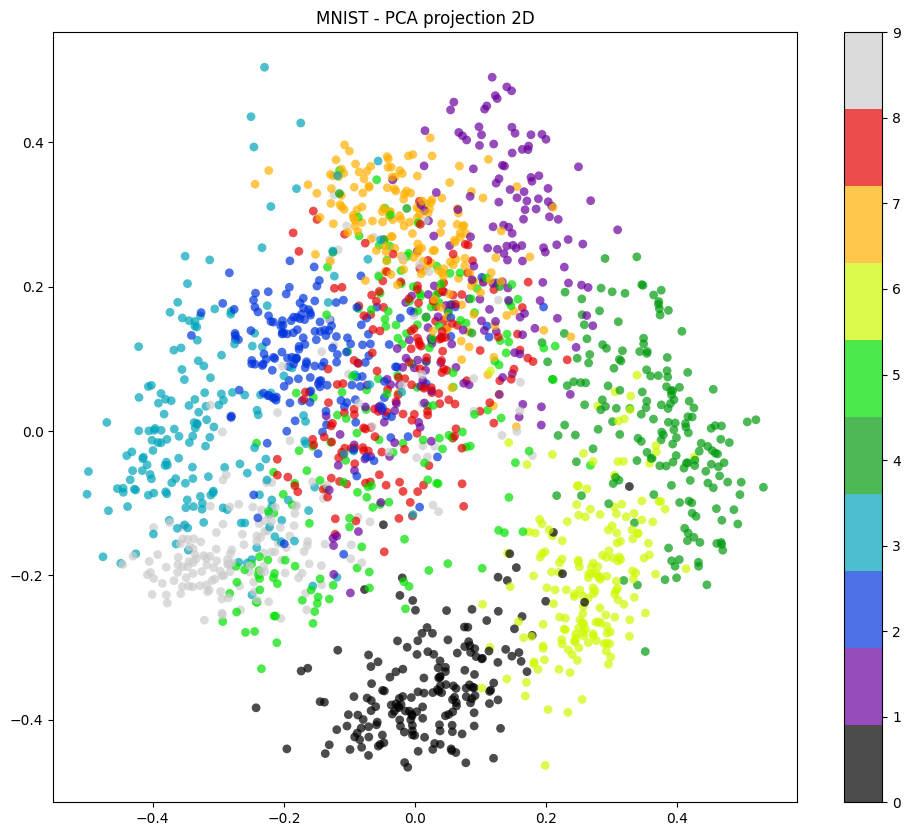

In [32]:
# Calculo el número de componentes máximo para inicializar la clase
n_samples, n_features = X.shape[0], X.shape[1]
components_to_start = min(n_samples, n_features)

# Inicializo la clase y obtengo explained_variance_ratio
pca = PCA_MNIST(X, y, n_components=components_to_start) 
explained_variance_ratio = pca.PCAModel.explained_variance_ratio_

# Calculo el número de componentes para explicar el 80% de la varianza
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
components_for_80 = np.argmax(cumulative_variance_ratio >= 0.8) + 1

print(f"Componentes para explicar el 80% de la varianza: {components_for_80}\n")

pca.plot_pca_space() 
plt.show()

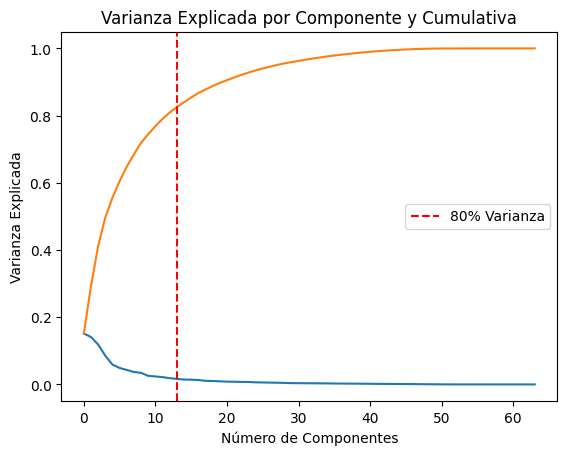

In [36]:
### 2. Gráficar la variación acumulada para cada caso.

pca.variance_plot(64)  # Grafico para el máximo de componentes
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada')
plt.axvline(x=13, color='r', linestyle='--', label='80% Varianza')
plt.legend()
plt.title('Varianza Explicada por Componente y Cumulativa')
plt.show()

C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Windows\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


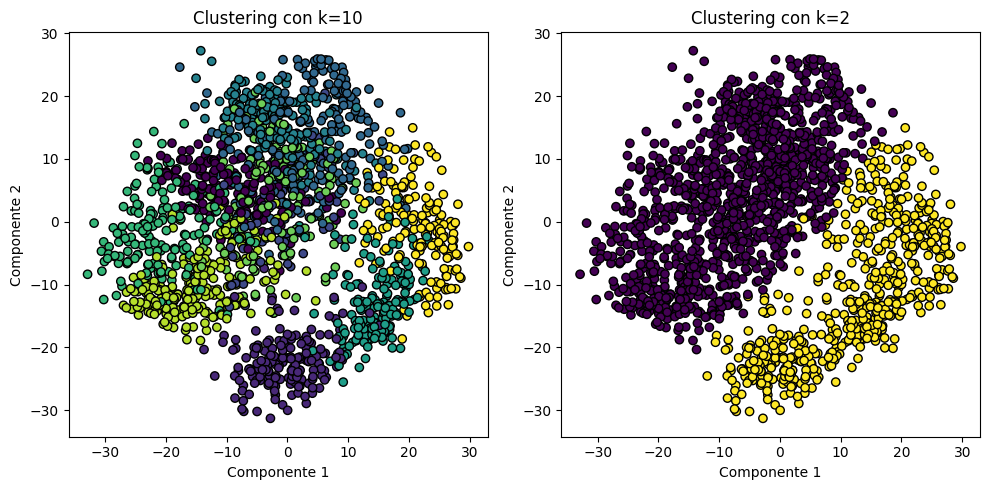

In [40]:
### 3. Utilizando [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).
### Agrupar el dataset transformado (ejercicio de PCA) y agrupar en clusters de k=10 y k=2.

from sklearn.cluster import KMeans

transformed_data = pca.PCA_transform(X)

# KMeans con k=10 y k=2
kmeans_10 = KMeans(n_clusters=10, random_state=42)
kmeans_2 = KMeans(n_clusters=2, random_state=42)

# Predicción con k=10 y k=2
clusters_10 = kmeans_10.fit_predict(transformed_data)
clusters_2 = kmeans_2.fit_predict(transformed_data)

### Graficar los resultados con los distintos k's usando las primeras dos componentes principales como ejes x,y.

# Ploteo los clusters para k=10
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=clusters_10, cmap='viridis', edgecolor='k')
plt.title('Clustering con k=10')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')

# Ploteo los clusters para k=2
plt.subplot(1, 2, 2)
plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=clusters_2, cmap='viridis', edgecolor='k')
plt.title('Clustering con k=2')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')

plt.tight_layout()
plt.show()


 5. Explique. ¿Cuál fue la ganancia de usar PCA en conjunto con k-means?
 
 La combinación de PCA y KMeans puede ofrecer una manera eficiente de manejar conjuntos de datos de alta dimensionalidad, mejorando la velocidad de cálculo, facilitando la interpretación y, en muchos casos, mejorando la calidad de los resultados de agrupamiento al centrarse en las características más relevantes de los datos.

## Ejercicio 9 (Opcional)  - Hice sólo una parte para probar

En este ejercicio vamos a crear un _clasificador_ de caras usando GMM

In [41]:
## importing basics libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## import olivetti faces dataset from sklearn
from sklearn.datasets import fetch_olivetti_faces

## import PCA, GMM and Scaler from sklearn
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

## import train_test_split from sklearn
from sklearn.model_selection import train_test_split

## import bic from sklearn
from sklearn.metrics import accuracy_score, f1_score

## import tsne for visualization
from sklearn.manifold import TSNE

## some utils
from tqdm.notebook import tqdm

### Paso 1: Preparación del Conjunto de Datos

1. Carga el conjunto de datos Olivetti Faces utilizando la función fetch_olivetti_faces de sklearn.

2. Imprimir la forma de las imágenes y las etiquetas objetivo.

3. Divide el conjunto de datos en un conjunto de entrenamiento y uno de prueba.


In [42]:
def plot_gallery(title, images, n_col=2, n_row=2):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

In [43]:
# Load faces data
dataset = fetch_olivetti_faces(shuffle = True, random_state = 42)
faces = dataset.data

n_samples, n_features = faces.shape

print("Dataset consists of %d faces" % n_samples)
print("Every image contains %d features" % n_features)

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\Windows\scikit_learn_data
Dataset consists of 400 faces
Every image contains 4096 features


In [44]:
dataset.target

array([20, 28,  3, 21,  9,  8, 32,  9, 26, 12,  0, 36,  5,  7, 13,  4, 27,
       37, 23, 38,  7,  1, 39, 27,  0, 39, 11, 22, 26, 10, 39, 19, 26,  5,
       23, 11, 11, 34, 15, 14, 38,  5,  7,  2,  8, 38, 14, 18,  2, 17,  4,
       32, 33,  7, 37,  3, 22, 17,  3, 15, 12, 29, 25,  7, 10,  3, 35, 26,
       39,  7, 32, 14,  0,  4, 38, 24, 22, 36, 17, 28,  0,  1, 20, 25, 27,
        6, 24, 30, 10,  9, 23, 33, 11, 22, 18, 31, 37, 38, 23,  7, 24, 11,
        1,  6, 15,  0,  1, 13, 35, 34, 13, 38, 29, 38, 29,  6,  7, 28, 30,
       28, 15, 10,  1, 34,  2, 17, 35, 33, 16, 24, 31, 14, 25, 17, 11, 19,
       22, 26, 21, 30,  3, 13, 29, 15, 19, 28,  5, 11, 16, 36,  0, 33, 27,
       15,  1, 19, 10,  8, 31, 39, 37, 20, 28, 16, 35,  8, 37, 16, 14, 22,
        9,  6, 12,  9, 14, 32,  9, 23,  6,  2,  3, 14, 12, 18,  6, 19, 32,
       21, 31, 19, 12, 14, 37,  8, 33, 34, 33, 35, 33, 30, 18, 20, 28, 21,
       28, 12,  3,  1, 32, 18, 22, 11, 17, 32, 29, 11, 36, 27, 38, 28, 36,
       16, 25, 13, 15, 19

In [45]:
## split dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    faces, dataset.target, test_size=0.2, random_state=42
)

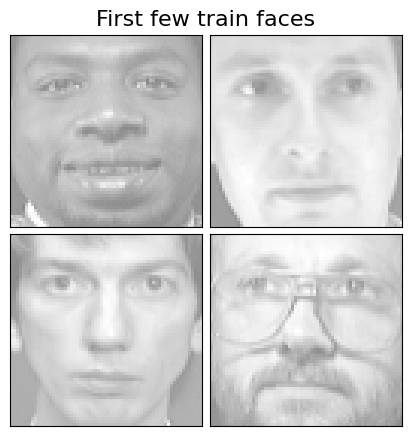

In [46]:
## plotting a few faces from train
n_col = 2
n_row = 2
image_shape = (64, 64)
plot_gallery("First few train faces", X_train[:n_col * n_row], n_col=n_col, n_row=n_row)

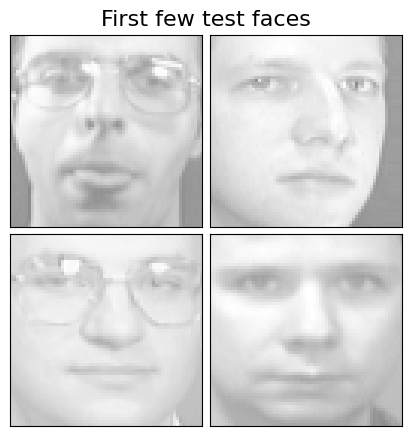

In [47]:
## plot some test faces
plot_gallery("First few test faces", X_test[:n_col * n_row], n_col=n_col, n_row=n_row)

### Paso 2: Visualización del dataset en el espacio de T-SNE

1. Ahora que importamos la libreria de T-SNE, inicializamos la clase.
2. Dado que queremos visualizar, deberiamos setear `n_components` en 2
o 3.

In [49]:
## use tsne to visualize the embeddings for train and test
tsne = TSNE(n_components=2)

## fit tsne on train and test
X_train_tsne = tsne.fit_transform(X_train)
X_test_tsne = tsne.fit_transform(X_test)

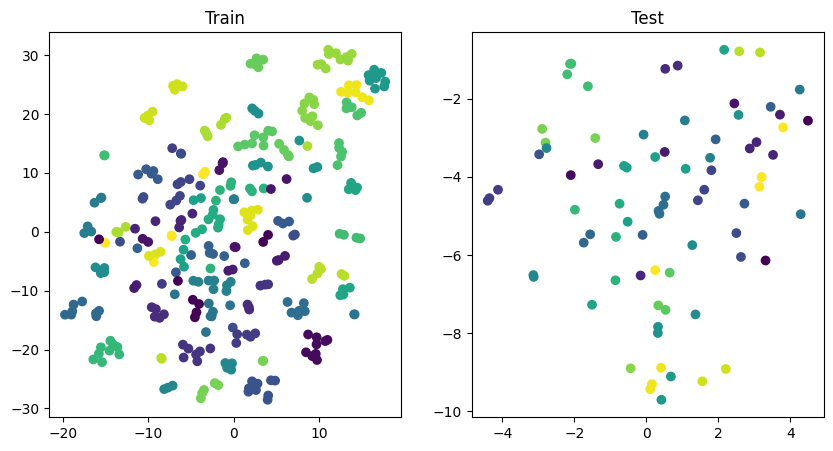

In [50]:
## plot the embeddings
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train)
plt.title("Train")
plt.subplot(1, 2, 2)
plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=y_test)
plt.title("Test")
plt.show()


### Paso 3: Entrenamos GMM para cada Persona

1. Vamos a crear una serie de modelos para cada target del modelo.
2. **NOTA:** La idea es que ustedes elijan el mejor numero de componentes
tomando por ejemplo el criterio de _BIC_

**NOTA 2:** Este paso puede representar una carga muy pesada de cálculo a su
computadora. Por ello vamos a analizar las primeras 10 caras del dataset solamente.


In [51]:
## filtering the first n_labels labels from the dataset

n_labels = 5

X_train_red = X_train[y_train <= n_labels]
X_test_red = X_test[y_test <= n_labels]

y_train_red = y_train[y_train <= n_labels]
y_test_red = y_test[y_test <= n_labels]

Vamos a crear un diccionario de modelos de GMM para las $n_labels$ caras
a analizar. La idea es que elijan la cantidad de componentes correctas.

En este esqueleto dejamos fijas 5 componentes

In [ ]:
# Create a dictionary to store the GMM for each person
gmms = {}

for i in tqdm(range(n_labels)):
    # Get the images of the current person
    person_images = X_train_red[y_train_red == i]

    # Train a GMM on these images
    gmm = GaussianMixture(
        n_components=5, random_state=42
    )
    gmm.fit(person_images)

    # Store the GMM in the dictionary
    gmms[i] = gmm


### Paso 4: Hora de predecir!!

Vamos a generar las nuevas clasificaciones con nuestros modelos de 
GMM.


In [ ]:
from typing import Dict, Any

In [ ]:
def get_best_pred(image: pd.Series, models: Dict[int, Any]) -> Dict[str, int]:
    best_person = None
    best_score = -np.inf

    scores = [gmm.score_samples([image]) for gmm in models.values()]

    ## now that we have the scores, we should get the model that has
    ## the highest score.
    return {
        "best_person": np.argmax(scores),
        "best_score": scores[np.argmax(scores)],
    }

In [ ]:
predictions = []

for image in tqdm(X_test_red):
    preds = get_best_pred(image, gmms)

    predictions.append(preds)

### Paso 5: Validamos el resultado

En este paso, Vamos a checkear el accuracy y el f1 de nuestro predictor.

In [ ]:
## Primero armamos un crosstab a ver si el modelo funciona.
pd.crosstab(
    y_test_red,
    [pred["best_person"] for pred in predictions],
    rownames=["True"],
    colnames=["Predicted"],
)

In [ ]:
accuracy_score(y_test_red, [pred["best_person"] for pred in predictions])

In [ ]:
f1_score(y_test_red, [pred["best_person"] for pred in predictions], average="macro")

### Paso 5: Conclusión

1. ¿Qué aprendiste de la visualización con t-SNE? ¿Cómo se desempeñó el GMM?

2. Discute las posibles mejoras que podrían realizarse en este modelo de detección de rostros.

## Ejercicio 10 (OPCIONAL)

El objetivo de este ejercicio es utilizar GMM para agrupar documentos de texto
basándose en sus características. Esto nos debería dar un buen pantallazo
del uso que podemos darle a los métodos de segmentación.

> ***NOTA***: Este ejercicio no tienen que entregarlo. Se los dejo para que puedan
tenerlo de referencia!

> ***NOTA:*** Aquí vamos a utilizar HuggingFace Transformers, tengan en cuenta
    que esto va a poner una carga posiblemente MUY grande en su computadora. 
    Si su compu no tiene muchos recursos por favor, avisenme y configuramos esto
    en Google colab para poder 

In [ ]:
## importing basics libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

## import train_test_split from sklearn
from sklearn.model_selection import train_test_split

## import tsne for visualization
from sklearn.manifold import TSNE

## Import GMM and PCA from sklearn
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture


## importing transformers libraries
from transformers import pipeline
import torch

## importing spacy library and en_core_web_lg model
import spacy

## importing 20newsgroups dataset from sklearn
from sklearn.datasets import fetch_20newsgroups

## some utils
from tqdm.notebook import tqdm

In [ ]:
import sys

sys.platform

In [ ]:
## check if the OS is Mac set device to "mps" if not, validate if cuda is available an set device to GPU or CPU
if sys.platform == "darwin":
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"


In [ ]:
## initializing the pipeline called embedding using bert-model-uncased from huggingface
## including the tokenizer and the model itself. GPU is used for faster inference if available.
pipe = pipeline(
    "feature-extraction",
    model="distilbert-base-uncased",
    tokenizer="distilbert-base-uncased",
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors="pt",
    device=device
)

Para inicializar el modelo de spacy, primero tenemos que descargar el modelo. Para ello corremos el siguiente comando

In [ ]:
!python -m spacy download en_core_web_sm

In [ ]:
## Initializing the spacy model. first it should be downloaded using the following command:
## python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")


### Paso 1: Preparación del Conjunto de Datos

1. Aquí, vamos a importar las bibliotecas principales que vamos a usar,
tales como NumPy, sklearn, pandas, etc.

2. Vamos a tomar el dataset 20 Newsgroups de sklearn.

3. Separación en train y test



In [ ]:
## importing the dataset and filtering only the first 5 labels
dataset = fetch_20newsgroups(
    shuffle=True,
    random_state=42,
    subset="train",
    remove=("headers", "footers", "quotes"),
    categories=[
        "comp.graphics",
        "comp.os.ms-windows.misc",
        "comp.sys.ibm.pc.hardware",
        "comp.sys.mac.hardware",
        "comp.windows.x",
    ],
)

## getting the data and perfoming some preprocessing such as removing the
## zero length strings and removing the new line characters.
data = dataset.data
data = [text.replace("\n", " ") for text in data if len(text) > 0]

## now removing the labels for the texts that were removed
labels = dataset.target[[len(text) > 0 for text in dataset.data]]

## converting all the texts to lowercase
data = [text.lower() for text in data]


## splitting the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42
)

In [ ]:
print("Dataset consists of %d texts" % len(data))
print("Train set consists of %d texts" % len(X_train))
print("Test set consists of %d texts" % len(X_test))


In [ ]:
## print some examples
for i in range(2):
    print(f"Example {i} - Label {y_train[i]}")
    print(X_train[i][:200])
    print("=========================================")

In [ ]:
## plot the histogram of the lengths of the texts
plt.figure(figsize=(10, 5))
plt.hist([len(text) for text in X_train], bins=100)
plt.show()


In [ ]:
## plot the distributions of the labels. both in train and test on the same graph
## on the X_label it should appear the name of the label and not the number.

plt.hist(y_train, alpha = 0.5, label = "Train")
plt.hist(y_test, alpha = 0.5, label = "Test")
plt.xticks(range(len(dataset.target_names)), dataset.target_names, rotation = 90)
plt.legend()
plt.show()


### Paso 2: Extracción de Características

En este paso vamos a utilizar dos tipos de embeddings, los embeddings de
transformers y los embeddings de SpaCy.

> **NOTA** Este paso puede ser MUY pesado para su compu. Tengan en cuenta
esto antes de correr estos pasos!

> En el caso que no puedan correr estas lineas, pueden ignorar este paso
y utilizar directamente los archivos que están provistos en la carpeta
`./data/embeddings/`

In [ ]:
train_embeddings = pipe(X_train)
test_embeddings = pipe(X_test)

In [ ]:
# now from embs we should get every embedding and get the mean of the embeddings
# for each text. this should be done for both train and test sets.
X_train_embs = np.array(
    [emb.mean(axis=1).detach().numpy().squeeze() for emb in tqdm(train_embeddings)]
)
X_test_embs = np.array(
    [emb.mean(axis=1).detach().numpy().squeeze() for emb in tqdm(test_embeddings)]
)

In [ ]:
## Es una buena recomendación guardar los embeddings en estos momentos. Así nos evitamos volver a calcularlos
## Guardamos entonces los embeddings en un archivo .parquet usando pandas.
## en el archivo de pandas vamos a guardar tanto los embeddings como las etiquetas de cada texto.
## las columnas de features deben llamarse "emb_0", "emb_1", etc.
## para guardar los embeddings en un archivo parquet, primero debemos convertirlos a un dataframe de pandas
## y luego usar el método to_parquet de pandas.

X_train_df = pd.DataFrame(X_train_embs, columns = [f"emb_{i}" for i in range(X_train_embs.shape[1])])
y_train_df = pd.DataFrame(y_train, columns = ["target"])
X_test_df = pd.DataFrame(X_test_embs, columns = [f"emb_{i}" for i in range(X_test_embs.shape[1])])
y_test_df = pd.DataFrame(y_test, columns = ["target"])

pd.concat([X_train_df, y_train_df], axis = 1).to_parquet("./data/embeddings/train_tf.parquet")
pd.concat([X_test_df, y_test_df], axis = 1).to_parquet("./data/embeddings/test_tf.parquet")

Ahora que generamos los embeddings con Tranformers, hacemos lo mismo pero con SpaCy

In [ ]:
# Para cada documento, utiliza Spacy para obtener el vector del documento
X_train_spacy = np.array([nlp(doc).vector for doc in tqdm(X_train)])
X_test_spacy = np.array([nlp(doc).vector for doc in tqdm(X_test)])

In [ ]:
X_train_df = pd.DataFrame(X_train_spacy, columns = [f"emb_{i}" for i in range(X_train_spacy.shape[1])])
y_train_df = pd.DataFrame(y_train, columns = ["target"])
X_test_df = pd.DataFrame(X_test_spacy, columns = [f"emb_{i}" for i in range(X_test_spacy.shape[1])])
y_test_df = pd.DataFrame(y_test, columns = ["target"])

pd.concat([X_train_df, y_train_df], axis = 1).to_parquet("./data/embeddings/train_sp.parquet")
pd.concat([X_test_df, y_test_df], axis = 1).to_parquet("./data/embeddings/test_sp.parquet")

### Paso 3: Aplicación de GMM

1. Aplica el GMM a las características de obtenidas (Tanto en transformers como en SpaCy). Experimenta con diferentes números de componentes.

2. Utiliza el GMM para predecir una etiqueta de cluster para cada documento.

Primero antes de arrancar es un buen momento de visualizar nuestros embeddings. Para ello,
primero vamos a cargar los embeddings.

recordemos que los embeddings con sufijo `_tf` corresponden al modelo de Transformers y
`_sp` corresponden al modelo de SpaCy.

In [ ]:
df_train = pd.read_parquet("./data/embeddings/train_tf.parquet")
df_test = pd.read_parquet("./data/embeddings/test_tf.parquet")

In [ ]:
df_train.shape

In [ ]:
## create a visualization of the embeddings using tsne.
## use the target to color the points.
## use the following colors: ["red", "blue", "green", "yellow", "orange"]

tsne = TSNE()
X_tsne = tsne.fit_transform(df_train.drop("target", axis = 1))

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c = df_train["target"], cmap = "rainbow")
plt.show()

Ahora si! vamos con GMM. Para ello primero vamos a utilizar PCA para poder
comprimir la informacion de los embeddings en algo más maleable.

Ahora evaluemos, como le fue al clusterizador?

In [ ]:
## Creamos una tabla de frecuencias cruzadas entre las etiquetas y los clusters.
pd.crosstab(df_pca_train['target'], df_pca_train['cluster'])

### Paso 4: Evaluación de los Resultados

1. Examinar algunos documentos de cada cluster. Tienen sentido los resultados?

2. Experimenta con diferentes números de clusters. Podemos encontrar algo interesante variando el parámetro
de `n_components`?

3. ¿Qué sucede si cambias el tipo de covarianza en el GMM? ¿Cómo afecta esto a los resultados?

4. Si hubiesemos usado kMeans como alternativa para clusterizar, hubiesemos tenido mejor resultado?

5. Entre el embedding de SpaCy y el embedding de Transformers, encontró alguna diferencia respecto
a la clusterización?